In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from deepsplines.ds_modules import dsnn
import torchviz
import wandb

In [20]:
np.random.seed(1)
torch.manual_seed(1)
torch.set_default_dtype(torch.float)
device = torch.device('cpu' if torch.backends.mps.is_available() else 'mps')

In [21]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Deepspline Auto Encoder for ECG",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "Deepline Linear Auto Encoder",
    "dataset": "ECG",
    "epochs": 2000,
    }
)

In [22]:
data       = np.load("./data/ecg_data.npz")
Xtr        = torch.tensor(data["Xtr"]).type(torch.float).to(device)    #Clean train
Xtr_noise  = torch.tensor(data["Xtr_noise"]).type(torch.float).to(device)  #Noisy train
Xte_noise  = torch.tensor(data["Xte_noise"]).type(torch.float).to(device)  #Noisy test

In [23]:
class Deepspline_AE(nn.Module):
    def __repr__(self):
        return {"model":"Deepsline_AE","K":self.K,"lr":self.lr,"epoch":self.epochs}
    
    def __init__(self, dim,K,opt_params,epoch=1000,lr=0.001):
        super(Deepspline_AE, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(dim, K),
            dsnn.DeepBSpline('fc', K, **opt_params),
            nn.Linear(K,dim)
            )
        self.lr=lr
        self.epochs=epoch
        self.criterion=nn.MSELoss(reduction="mean")
        self.K=K

    def forward(self, x):
        x = self.model(x)
        return x
    
    def reconstruct(self,x,W,V):
        self.model[0].weight.data=W
        self.model[2].weight.data=V
        x=self.model(x)
        return x
    
    def loss(self,X,X_hat):
        return self.criterion(X,X_hat).item()
    
    def fit(self,X,R):
        train_loss_list=[]
        optimizer=optim.Adam(self.parameters(),lr=self.lr)
        for epoch in range(self.epochs+1):
            train_loss = 0.0
            self.model.train()
            optimizer.zero_grad()
            output = self.model(X)
            loss = self.criterion(output, R)
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss)
            wandb.log({"loss": loss.item()}, step=epoch)
            # for name, param in self.named_parameters():
            #     wandb.log({name: param}, step=epoch)
            if(epoch%100==0):print('Epoch [{}/{}], Train Loss: {:.9f}'.format(epoch, self.epochs, loss))
        self.saver(self.model.state_dict())
        return train_loss_list[-1]

    def test(self,X,R):
        self.model.eval()
        with torch.no_grad():
            output=self.model(X)
            loss=self.criterion(output,R)
            return loss

    def print_param(self):
        for param in self.parameters():
            print(f'parameter shape:{param.shape}')
            #print(f'parameter value:{param.data}')
    
    @staticmethod
    def plot_loss(X,X_hat):
        time=len(X)
        plt.plot(range(1, time+1), X.cpu().detach().numpy(), label='Noisy Data')
        plt.plot(range(1, time+1), X_hat.cpu().detach().numpy(), label='Reconstructed Data')
        plt.xlabel('Time')
        plt.ylabel('ECG')
        plt.title('Noisy Data vs. Reconstructed Data')
        plt.legend()
        plt.show()

    def saver(self,best_weights,PATH="./models"):
        name=''.join(f"{key}{val}" for key, val in self.__repr__().items())
        path=PATH+"/"+name
        torch.save(best_weights,path)

In [24]:
opt_params = {
    'size': 21, #knots k+2
    'range_': 6,
    'init': 'leaky_relu',
    'save_memory': False
}


In [27]:
model=Deepspline_AE(100,70,opt_params,epoch=1500,lr=0.01).to(device)
wandb.init(project='Deepspline Auto Encoder for ECG')
wandb.watch(model,log= "all",log_freq=10)
loss=model.fit(Xtr_noise,Xtr)
x_hat=model.forward(Xtr_noise)

loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.15428


Epoch [0/1500], Train Loss: 2.658607483
Epoch [100/1500], Train Loss: 0.065525688
Epoch [200/1500], Train Loss: 0.053743713
Epoch [300/1500], Train Loss: 0.050326437
Epoch [400/1500], Train Loss: 0.048662830
Epoch [500/1500], Train Loss: 0.049342319
Epoch [600/1500], Train Loss: 0.047113162
Epoch [700/1500], Train Loss: 0.047400337
Epoch [800/1500], Train Loss: 0.046119515
Epoch [900/1500], Train Loss: 0.046866670
Epoch [1000/1500], Train Loss: 0.046135597
Epoch [1100/1500], Train Loss: 0.045392491
Epoch [1200/1500], Train Loss: 0.045513161
Epoch [1300/1500], Train Loss: 0.046470255
Epoch [1400/1500], Train Loss: 0.044765607
Epoch [1500/1500], Train Loss: 0.044879138


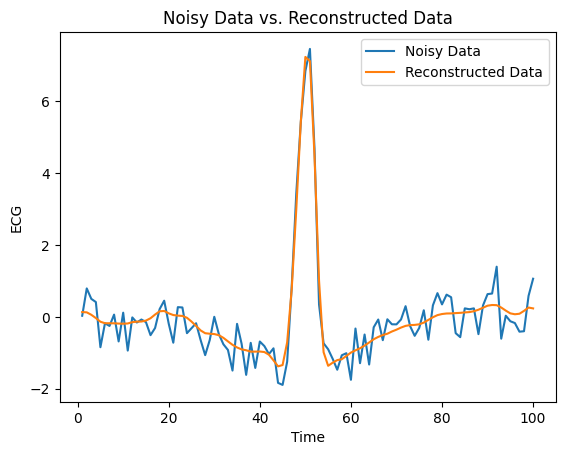

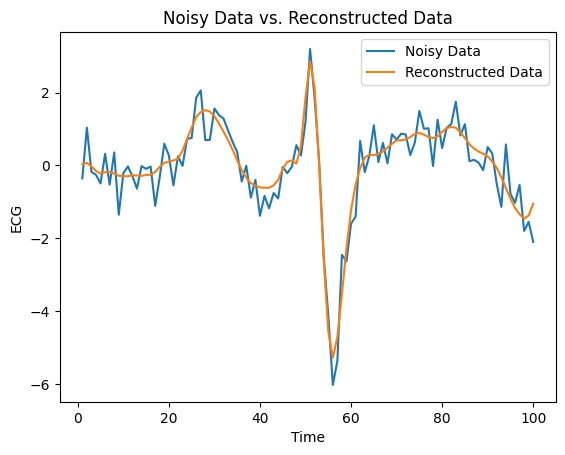

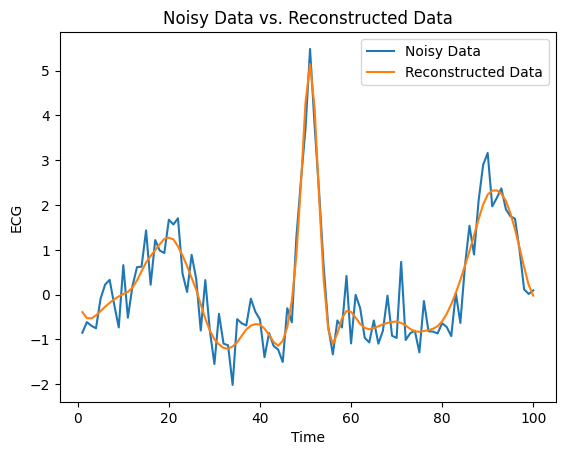

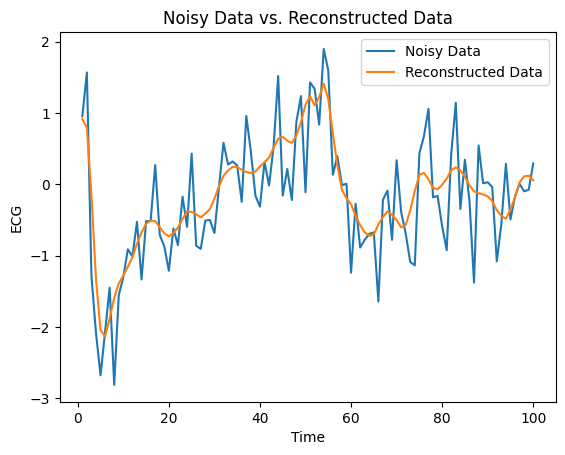

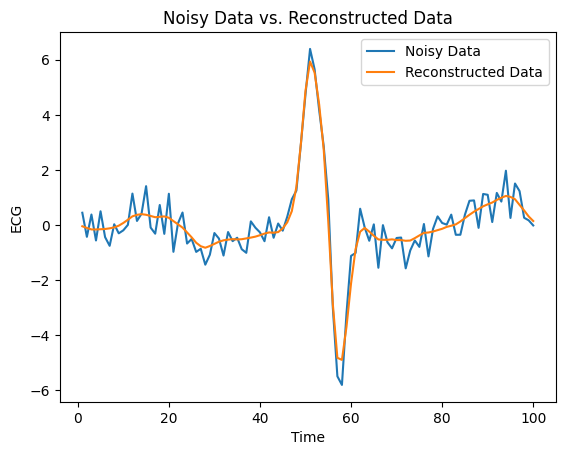

In [28]:
for i in range(5):
    model.plot_loss(Xtr_noise[i],x_hat[i])

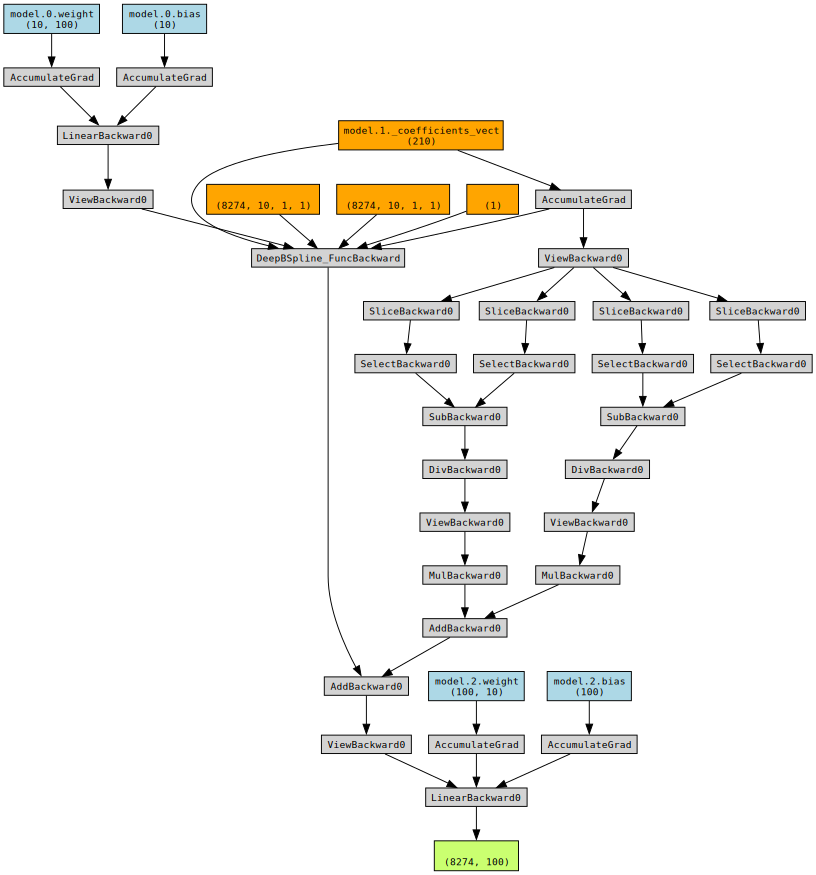

In [11]:
torchviz.make_dot(x_hat,params=dict(model.named_parameters()))

[]